In [35]:
import os
import cv2
import pdb
import time
import warnings
import random
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset, sampler
from matplotlib import pyplot as plt
from albumentations import (HorizontalFlip, VerticalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
from albumentations.pytorch import ToTensorV2

In [36]:
#Fix alll random seeds for repeatability
def fix_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True




In [37]:
fix_all_seeds(42)

torch.cuda.empty_cache()

In [38]:
TEST = False
data_directory = 'data'
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
BATCH_SIZE = 8
NUM_EPOCHS = 30

TRAIN_CSV = 'data/train.csv'
TRAIN = 'data/train'
TEST = 'data/test'

RESNET_MEAN = (0.485, 0.456, 0.406)
RESNET_STD = (0.229, 0.224, 0.225)

# (336, 336)
IMAGE_RESIZE = (224, 224)

LEARNING_RATE = 5e-4
EPOCHS = 12


In [39]:
df_train = pd.read_csv(TRAIN_CSV)
df_train.head()

,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta
0,0030fd0e6378,118145 6 118849 7 119553 8 120257 8 120961 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
1,0030fd0e6378,189036 1 189739 3 190441 6 191144 7 191848 8 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
2,0030fd0e6378,173567 3 174270 5 174974 5 175678 6 176382 7 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
3,0030fd0e6378,196723 4 197427 6 198130 7 198834 8 199538 8 2...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
4,0030fd0e6378,167818 3 168522 5 169225 7 169928 8 170632 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00


In [40]:
def rle_decode(mask_rle, shape, color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
    return img.reshape(shape)


def build_masks(df_train, image_id, input_shape):
    height, width = input_shape
    labels = df_train[df_train["id"] == image_id]["annotation"].tolist()
    mask = np.zeros((height, width))
    for label in labels:
        mask += rle_decode(label, shape=(height, width))
    mask = mask.clip(0, 1)
    return mask

In [41]:
class CellDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.base_path = TRAIN
        self.transforms = Compose([Resize(IMAGE_RESIZE[0], IMAGE_RESIZE[1]), 
                                   Normalize(mean=RESNET_MEAN, std=RESNET_STD, p=1), 
                                   HorizontalFlip(p=0.5),
                                   VerticalFlip(p=0.5),
                                   ToTensorV2()])
        self.gb = self.df.groupby('id')
        self.image_ids = df.id.unique().tolist()

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        df = self.gb.get_group(image_id)
        annotations = df['annotation'].tolist()
        image_path = os.path.join(self.base_path, image_id + ".png")
        image = cv2.imread(image_path)
        mask = build_masks(df_train, image_id, input_shape=(520, 704))
        mask = (mask >= 1).astype('float32')
        augmented = self.transforms(image=image, mask=mask)
        image = augmented['image']
        mask = augmented['mask']
        return image, mask.reshape((1, IMAGE_RESIZE[0], IMAGE_RESIZE[1]))

    def __len__(self):
        return len(self.image_ids)

In [42]:
ds_train = CellDataset(df_train)
image, mask = ds_train[1]
image.shape, mask.shape

(torch.Size([3, 224, 224]), torch.Size([1, 224, 224]))

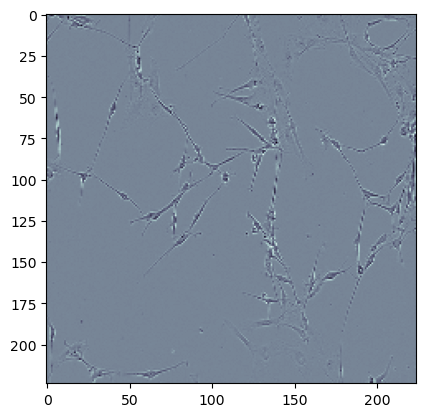

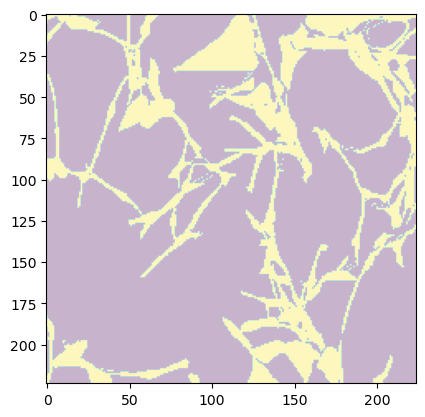

In [43]:
plt.imshow(image[0], cmap='bone')
plt.show()
plt.imshow(mask[0], alpha=0.3)
plt.show()

In [44]:
dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True, shuffle=False)

In [45]:
len(dl_train)

76

In [46]:
batch = next(iter(dl_train))
images, masks = batch

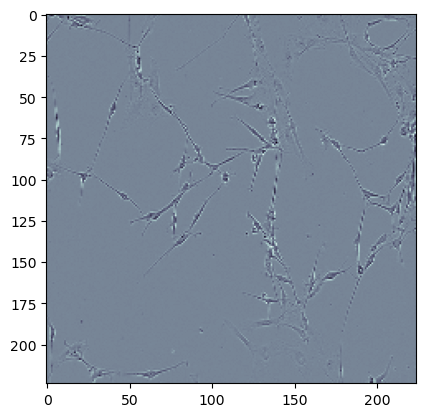

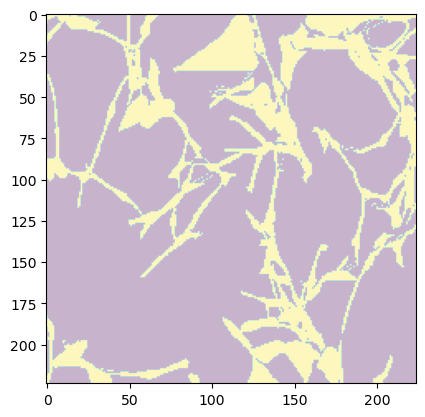

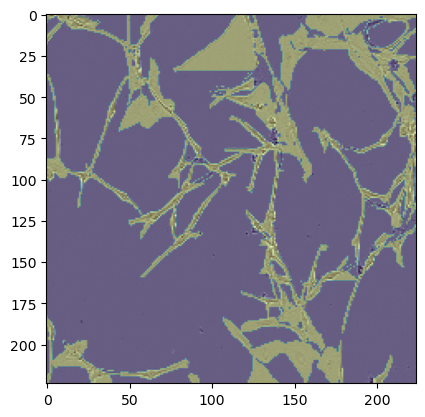

In [47]:
idx=1
plt.imshow(images[idx][0], cmap='bone')
plt.show()
plt.imshow(masks[idx][0], alpha=0.3)
plt.show()
plt.imshow(images[idx][0], cmap='bone')
plt.imshow(masks[idx][0], alpha=0.3)
plt.show()

In [48]:
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))


class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma

    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))
        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()
        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        return loss.mean()

class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)

    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()

In [49]:
import torch
import collections.abc as container_abcs
torch._six.container_abcs = container_abcs
import segmentation_models_pytorch as smp

In [50]:
model = smp.Unet("mobilenet_v2", encoder_weights="imagenet", activation=None)

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 3.82 GiB total capacity; 2.70 GiB already allocated; 4.62 MiB free; 2.72 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
torch.set_default_tensor_type("torch.cuda.FloatTensor")
n_batches = len(dl_train)

model.cuda()
model.train()

criterion = MixedLoss(10.0, 2.0)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

for epoch in range(1, EPOCHS + 1):
    print(f"Starting epoch: {epoch} / {EPOCHS}")
    running_loss = 0.0
    optimizer.zero_grad()
    
    for batch_idx, batch in enumerate(dl_train):
        
        # Predict
        images, masks = batch
        images, masks = images.cuda(),  masks.cuda()
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        # Back prop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.item()

    epoch_loss = running_loss / n_batches
    print(f"Epoch: {epoch} - Train Loss {epoch_loss:.4f}")

Starting epoch: 1 / 12


OutOfMemoryError: CUDA out of memory. Tried to allocate 14.00 MiB (GPU 0; 3.82 GiB total capacity; 2.69 GiB already allocated; 10.62 MiB free; 2.71 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF